In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

In [2]:
directory = 'C:/Users/geeze/Documents/finances/utils/'
file = 'utilities_tidy_1415fairoaks.xlsx'

utils_fo = pd.read_excel(directory + file)

In [3]:
utils_fo.head()

,open,close,util,amnt,note,lauren paid
0,2019-06-26,2019-07-25,internet,54.98,opening charges of $10,1
1,2019-07-26,2019-08-25,internet,44.99,NaN,1
2,2019-07-01,2019-07-12,gas,31.09,just 11 days billed,1
3,2019-08-26,2019-09-25,internet,44.99,NaN,1
4,2019-07-01,2019-07-29,elec,47.39,there are two accounts for whatever reason so ...,1


In [4]:
gas_g = 'gas'
elec_e = 'elec'
inte_i = 'internet'

gas = utils_fo['util'] == gas_g
elec = utils_fo['util'] == elec_e
inte = utils_fo['util'] == inte_i

### Handle gas

In [5]:
g = utils_fo.loc[gas]

In [6]:
def ismid (d):
    day = d.day
    
    if day == 1:
        return False
    else:
        return True

In [7]:
def change_to_1 (d):
    mo = d.month
    yr = d.year
    
    d = datetime.datetime(yr,mo,1)
        
    return d

In [8]:
#calculate the values that will be split between the opening month and closing month since billing period straddles a month
mids_to_split = g['open'].apply(ismid)

g.loc[mids_to_split,'split'] = g.loc[mids_to_split,'amnt']/2

C:\Users\geeze\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\geeze\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
#hack your way to tables that associate the split value with the opening month and closing month
first = g.loc[:,['open', 'split']].dropna().rename(columns={'open':'date'})
sec = g.loc[:,['close', 'split']].dropna().rename(columns={'close':'date'})

In [10]:
g

,open,close,util,amnt,note,lauren paid,split
2,2019-07-01,2019-07-12,gas,31.09,just 11 days billed,1,NaN
7,2019-07-12,2019-08-12,gas,13.39,NaN,1,6.695
8,2019-08-12,2019-09-11,gas,12.00,NaN,1,6.000
9,2019-09-11,2019-10-10,gas,14.13,NaN,1,7.065
10,2019-10-10,2019-11-08,gas,21.17,NaN,0,10.585
11,2019-11-08,2019-12-11,gas,20.95,NaN,0,10.475
17,2019-12-11,2020-01-11,gas,13.17,NaN,0,6.585


In [11]:
#generate a table with the split values associated with the two months the billing period straddles
new_gas = pd.concat([first, sec])
new_gas['date'] = new_gas['date'].apply(change_to_1)
new_gas['util'] = gas_g

#add back the first entry
add = g.reset_index(drop=True).loc[0, ['open', 'util', 'amnt']].rename({'open':'date', 'amnt':'split'})
new_gas = new_gas.append(add,ignore_index=True).rename(columns={'split':'amnt'})

In [12]:
new_gas.sort_values(by='date')

,date,amnt,util
0,2019-07-01,6.695,gas
12,2019-07-01,31.090,gas
1,2019-08-01,6.000,gas
6,2019-08-01,6.695,gas
2,2019-09-01,7.065,gas
7,2019-09-01,6.000,gas
3,2019-10-01,10.585,gas
8,2019-10-01,7.065,gas
4,2019-11-01,10.475,gas
9,2019-11-01,10.585,gas


### Handle electricity

In [13]:
e = utils_fo.loc[elec]

In [14]:
e.head()

,open,close,util,amnt,note,lauren paid
4,2019-07-01,2019-07-29,elec,47.39,there are two accounts for whatever reason so ...,1
5,2019-07-29,2019-08-27,elec,50.53,NaN,1
6,2019-08-27,2019-09-26,elec,72.39,NaN,1
12,2019-09-26,2019-10-28,elec,16.98,NaN,0
13,2019-10-28,2019-11-26,elec,37.68,NaN,0


In [15]:
#these date ranges are basically all in the closing month, so just allocate them all to the close month section
e['date'] = pd.to_datetime(e.open) + pd.offsets.MonthBegin(0)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
new_e = e.loc[:,['date', 'amnt','util']]

In [17]:
new_e.sort_values(by='date')

,date,amnt,util
4,2019-07-01,47.39,elec
5,2019-08-01,50.53,elec
6,2019-09-01,72.39,elec
12,2019-10-01,16.98,elec
13,2019-11-01,37.68,elec
18,2019-12-01,49.37,elec
19,2020-01-01,34.18,elec


### Handle internet

In [18]:
i = utils_fo.loc[inte]

In [19]:
#these date ranges are basically all in the closing month, so just allocate them all to the close month section
i['date'] = pd.to_datetime(i.open) + pd.offsets.MonthBegin(0)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
new_i = i.loc[:,['date', 'amnt','util']]

In [21]:
new_i

,date,amnt,util
0,2019-07-01,54.98,internet
1,2019-08-01,44.99,internet
3,2019-09-01,44.99,internet
14,2019-10-01,44.99,internet
15,2019-11-01,44.99,internet
16,2019-12-01,44.99,internet
20,2020-01-01,44.99,internet
21,2020-02-01,44.99,internet


### stick all together

In [22]:
all_util_outs = pd.concat([new_gas, new_e, new_i])

In [23]:
all_util_outs

,date,amnt,util
0,2019-07-01,6.695,gas
1,2019-08-01,6.000,gas
2,2019-09-01,7.065,gas
3,2019-10-01,10.585,gas
4,2019-11-01,10.475,gas
5,2019-12-01,6.585,gas
6,2019-08-01,6.695,gas
7,2019-09-01,6.000,gas
8,2019-10-01,7.065,gas
9,2019-11-01,10.585,gas


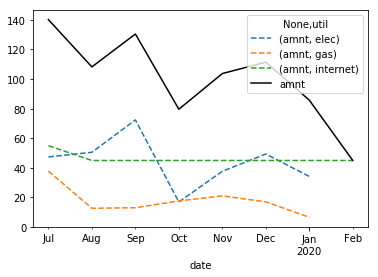

In [24]:
fig, ax = plt.subplots()

#divide up the totals by utility type
f_grouped = all_util_outs.groupby('util').resample('M', on='date').sum()


#just do the resampling and summing on everything, regardless of category, silly to do this twice, but whatever
f = all_util_outs.resample('M', on='date').sum()


#plot each utility value
f_grouped.unstack(level=0).plot(linestyle='--', ax=ax)

#plot the total
f.plot(ax=ax, c='k')


In [25]:
f['div 2 roommates'] = f['amnt']/2
f.to_csv(directory + 'fairoaks_utils_monthly.csv')